# Store locations
*__Finding the optimal location for a low-cost supermarket in Madrid__*

## Table of Contents

* [Introduction](#introduction)
    * [Background](#background)
    * [Business problem](#business-problem)
* [Data](#data)
    * [Wikipedia](#wikipedia)
    * [Geospatial data](#geospatial-data)
    * [Census data](#census-data)
* [Methodology](#methodology)
    * [Data acquisition](#data-acquisition)
        * [Scrapping Wikipedia](#scrapping-wikipedia)
        * [Requesting Foursquare API for geospatial data](#requesting-foursquare)
        * [Loading census data file](#loading-census)
    * [Neighbourhood segmentation](#neighbourhood-segmentation)
    * [Census analysis](#census-analysis)
* [Results and discussion](#results-and-discussion)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="introduction"></a>

### Background <a class="anchor" id="background"></a>

Opening a physical store is not without risks. One the most obvious risks to evaluate before opening a new store is receiving enough customers to make the business profitable. Therefore it is essential to pick the right location to make sure it is convenient for the customers and there is enough demand for a new store in the area.

Identifying the target customers is also key taking into account the behaviour of the different groups of consumers and the stores they usually buy at.

### Business problem <a class="anchor" id="business-problem"></a>

In this project, we tackle the problem of a low-cost supermarket chain trying to decide in which area of Madrid (Spain) they should open their new store in order to maximise the revenue. It is important to note that the city of Madrid consists of 21 districts and 131 neighbourhoods with great differences between them. 

The goal is to identify the optimal neighbourhood for opening a store taking different factors into consideration such as the types of neighbourhood (a residential area would be ideal), the amount of people living in those areas (the higher the population the higher the food demand), their average income (working class people are preferred) and the stores that are already available (avoiding areas with a big density of supermarkets).

Using data science, geospatial analysis and machine learning techniques, this project aims to provide a solution for this problem and recommending the best neighbourhood for opening the low-cost supermarket.

## Data <a class="anchor" id="data"></a>

The following sections describe the data that is needed for answering this business question.

### Wikipedia <a class="anchor" id="wikipedia"></a>

The first data that we need is the list of neighbourhoods in Madrid. Even though this information could have been directly obtained from a CSV file from Madrid city council, it has been decided to use web scraping on Wikipedia for learning purposes.

The Wikipedia page “List of neighbourhoods of Madrid” shows a table with the name of each neighbourhood for each of the 21 districts. In our project, we will work directly with the neighbourhoods and ignore the districts since this way we can perform a more granular analysis of the areas.

<p align="center">
  <img width="500" height="500" src="img/wikipedia_madrid.png">
</p>

<p style="text-align: center;">
    Source: 
    <a href="https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Madrid">https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Madrid</a>
</p>

### Geospatial data <a class="anchor" id="geospatial-data"></a>

Since the plan is to target residential areas, we need to analyse the type of food venues present in each neighbourhood. With the Foursquare API we can explore the different food venues, considering that a big density of bars and restaurants over very few supermarkets will most likely refer to a business or recreational area where people don’t usually buy at supermarkets. In the other hand, a large proportion of supermarkets over the rest of food venues might indicate it is a residential area where people normally make their food shopping.

Before we can make use of the Foursquare API we need to convert the neighbourhood names into a pair of latitude and longitude coordinates. We can acquire this with the _geocoder_ Python library.
We can query the Foursquare API using the HTTP GET method on the explore endpoint indicating the geographical coordinates, venue categories and radius.

<p align="center">
  <img width="500" height="500" src="img/foursquare_api.png">
</p>

<p style="text-align: center;">
    Source: 
    <a href="https://developer.foursquare.com/docs/api-reference/venues/explore/">https://developer.foursquare.com/docs/api-reference/venues/explore/</a>
</p>

### Census data <a class="anchor" id="census-data"></a>

Finally we will need data from the census of Madrid. We can obtained this data from Excel files that are accessible from the Madrid city council website. Particularly we are interested in the population and the average income of each neighbourhood.

<p align="center">
  <img width="500" height="500" src="img/census_population.png">
</p>

<p style="text-align: center;">
    Source: 
    <a href="http://www-2.munimadrid.es/TSE6/control/seleccionDatosBarrio">http://www-2.munimadrid.es/TSE6/control/seleccionDatosBarrio</a>
</p>

<p align="center">
  <img width="500" height="500" src="img/census_income.png">
</p>

<p style="text-align: center;">
    Source: 
    <a href="https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=d029ed1e80d38610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default">https://datos.madrid.es/portal/site/egob</a>
</p>

## Methodology <a class="anchor" id="methodology"></a>

The following sections describe the different stages of this project, starting with the acquisition of the data (venues and census), following with the clustering of the neighbourhoods and finishing with an analysis of the census for the corresponding group of neighbourhoods.

### Libraries import

In [992]:
# for HTTP requests
import requests  

# for HTML scrapping 
from bs4 import BeautifulSoup 

# for table analysis
import pandas as pd
import numpy as np

# for finding geographical coordinates
import geocoder

# for converting an address into latitude and longitude values
from geopy.geocoders import Nominatim

# for rending maps
import folium

# for removing Spanish accents from map labels in Folium (encoding incompatibility)
import unicodedata

# for clustering neighbourhoods
from sklearn.cluster import KMeans

# for drawing the elbow method and scatterplot
import matplotlib.pyplot as plt

# for displaying map of clusters
import matplotlib.cm as cm
import matplotlib.colors as colors

# for displaying the scatterplot of household income vs people per market
import seaborn as sns

# for arranging labels around the scatterplot to avoid overlapping neighbourhood names
from adjustText import adjust_text

### Data acquisition <a class="anchor" id="data-acquisition"></a>

The following sub-sections describe the methodology to obtain the different datasets, either by loading an external file or by scrapping a website.

#### Scrapping Wikipedia <a class="anchor" id="scrapping-wikipedia"></a>

__URL for Wikipedia article__

In [933]:
# URL of wikipedia page from which to scrap tabular data.
wiki_url = "https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Madrid"

__Request & Response__

In [934]:
# If the request was successful, reponse should be '200'.
response = requests.get(wiki_url) #.json()
response

<Response [200]>

__Wrangling HTML With BeautifulSoup__

In [935]:
# Parse response content to html
soup = BeautifulSoup(response.content, 'html.parser')
#soup

__Viewing HTML content__

In [936]:
# Title of Wikipedia page
title = soup.title.string
print(f'Page title: {title}') 

# Find the right table to scrap
wiki_table=soup.find('table', {"class":'wikitable sortable'})

# Get the 1st row of the table i.e. the header
row0 = wiki_table.findAll("tr")[0]

# Show the column names (we're only interested in "Name" i.e. the 4th column)
header = [th.text.rstrip() for th in row0.find_all('th')]
print(f'Column names: {header}') 

Page title: List of neighborhoods of Madrid - Wikipedia
Column names: ['District name (number)', 'District location', 'Number', 'Name', 'Image']


__Scraping the table contents__

In [937]:
# Placeholder for list of neighbourhoods
madrid_neighbourhoods = []

# Iterate through the rows of the table
# Note: each district has sub-rows of neighbourhoods
for row in wiki_table.findAll("tr"):    
    cells = row.findAll('td')

    # Parse 1st neighbourhood of the district
    if len(cells)==5:
        madrid_neighbourhoods.append(cells[3].find(text=True).replace('\n', '').rstrip().lstrip().upper())
    
    # Parse sub-rows (rest of neighbourhoods of the district)
    elif len(cells)==3:
        madrid_neighbourhoods.append(cells[1].find(text=True).replace('\n', '').rstrip().lstrip().upper())
    
print(f'Number of neighbourhoods: {len(madrid_neighbourhoods)}')

Number of neighbourhoods: 131


__Creating a dataframe__

In [938]:
df_madrid = pd.DataFrame(madrid_neighbourhoods, columns=['Neighbourhood'])
print(f'Shape: {df_madrid.shape}')
df_madrid.head()

Shape: (131, 1)


,Neighbourhood
0,PALACIO
1,EMBAJADORES
2,CORTES
3,JUSTICIA
4,UNIVERSIDAD


__Getting geographical coordinates for the neighbourhoods__

In [940]:
# Geocoder fails to locate some of the neighbourhoods correctly and therefore it is necessary
# to request the coordinates using a different name for these particular areas.
def rename(neighbourhood):
    new_name = neighbourhood
    if new_name == 'CASCO HISTÓRICO DE VICÁLVARO':
        new_name = 'VICÁLVARO'
    elif new_name == 'QUINTANA':
        new_name = 'PARQUE DE CALERO'
    elif new_name == 'BUTARQUE':
        new_name = 'VILLAVERDE BAJO'
    return new_name

# Function that retrieves the geographical coordinates for a given neighborhood
def get_coordinates(row):
    # initialize variable to None
    lat_lng_coords = None

    # loop until we get the coordinates
    while(lat_lng_coords is None):
      g = geocoder.arcgis(f'{rename(row["Neighbourhood"])}, Madrid')
      lat_lng_coords = g.latlng
    
    # return pair lat,long
    return pd.Series([lat_lng_coords[0], lat_lng_coords[1]])

In [941]:
# Fill coordinates for each row
df_madrid[['Latitude','Longitude']] = df_madrid.apply(get_coordinates, axis=1)
df_madrid.head()

,Neighbourhood,Latitude,Longitude
0,PALACIO,40.41517,-3.71273
1,EMBAJADORES,40.40803,-3.70067
2,CORTES,40.41589,-3.69636
3,JUSTICIA,40.42479,-3.69308
4,UNIVERSIDAD,40.42565,-3.70726


In [942]:
# Make sure we found the coordinates for all the neighbourhoods
df_madrid.isnull().sum()

Neighbourhood    0
Latitude         0
Longitude        0
dtype: int64

__Visualizing the neighbourhoods of Madrid__

In [943]:
address = 'Madrid, Spain'
geolocator = Nominatim(user_agent="madrid_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinates of Madrid are {latitude}, {longitude}')

The geograpical coordinates of Madrid are 40.4167047, -3.7035825


In [944]:
# Spanish accents are not correctly rendered in the map labels so we decided
# to remove them for a better understanding of the map
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode("utf-8")

In [945]:
# create map of Madrid using latitude and longitude values
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_madrid['Latitude'], df_madrid['Longitude'], df_madrid['Neighbourhood']):
    label = folium.Popup(remove_accents(label), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

#### Requesting Foursquare API for geospatial data <a class="anchor" id="requesting-foursquare"></a>

In [946]:
CLIENT_ID = 'BHJXSXUIL3QMVG5D40DTXTROBNKAMXXYNZSISUHVXAL3HXZO' # Foursquare ID
CLIENT_SECRET = 'FRLBLH40G0T4OWROEXCQU3MY35OZAIE3HXJ5J1X02RXNMTWP' # Foursquare Secret
ACCESS_TOKEN = 'N1LDGNZGUPHICQM1Y5LRR5RMQGULD1MLDZQIISPLTI0CL4I0' # FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('ACCESS_TOKEN:' + ACCESS_TOKEN)

Credentails:
CLIENT_ID: BHJXSXUIL3QMVG5D40DTXTROBNKAMXXYNZSISUHVXAL3HXZO
CLIENT_SECRET:FRLBLH40G0T4OWROEXCQU3MY35OZAIE3HXJ5J1X02RXNMTWP
ACCESS_TOKEN:N1LDGNZGUPHICQM1Y5LRR5RMQGULD1MLDZQIISPLTI0CL4I0


In [948]:
# Function to find venues in a given neighbourhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results if v['categories']])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

__Run the above function to each neighbourhood__

In [949]:
# Search for venues within 1Km of radius from the neighbourhood centre point
radius = 1000

madrid_venues = getNearbyVenues(names=df_madrid['Neighbourhood'],
                                   latitudes=df_madrid['Latitude'],
                                   longitudes=df_madrid['Longitude'],
                                   radius=radius)

print(madrid_venues.shape)
madrid_venues.head()

(11880, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PALACIO,40.41517,-3.71273,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
1,PALACIO,40.41517,-3.71273,Instituto Italiano de Cultura,40.415197,-3.712883,General College & University
2,PALACIO,40.41517,-3.71273,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
3,PALACIO,40.41517,-3.71273,Consejo De Estado,40.415129,-3.713384,Government Building
4,PALACIO,40.41517,-3.71273,Iglesia Catedral de las Fuerzas Armadas,40.415114,-3.712331,Church


__Analysing each neighbourhood__

In [950]:
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
madrid_onehot['Neighbourhood'] = madrid_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]

print(f'Size: {madrid_onehot.shape}')
madrid_onehot.head()

Size: (11880, 502)


,Neighbourhood,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,African Restaurant,Airport,Airport Gate,Airport Lounge,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,PALACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,PALACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PALACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PALACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PALACIO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Grouping rows by neighbourhood and finding frequency of each category__

In [951]:
madrid_grouped = madrid_onehot.groupby('Neighbourhood').mean().reset_index()
print(f'Size: {madrid_grouped.shape}')
madrid_grouped.head()

Size: (131, 502)


,Neighbourhood,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,African Restaurant,Airport,Airport Gate,Airport Lounge,...,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,ABRANTES,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
1,ACACIAS,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.010417,0.010417,0.0,0.0,0.0,0.0,0.010417
2,ADELFAS,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
3,AEROPUERTO,0.032787,0.0,0.0,0.0,0.0,0.0,0.016393,0.540984,0.016393,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
4,ALAMEDA DE OSUNA,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


#### Loading census data file<a class="anchor" id="loading-census"></a>

__Population by neighbourhood__

In [952]:
# Load data from file taking into account the table headers are on the 4th row and the population need to be converted to integer.
df_madrid_population = pd.read_excel('files/madrid_population.xls', header=3, names=['District', 'Neighbourhood', 'Population'], nrows=131, converters={'Total': int})
print(df_madrid_population.shape)
df_madrid_population.head()

(131, 3)


,District,Neighbourhood,Population
0,CENTRO,PALACIO,23691
1,CENTRO,EMBAJADORES,47460
2,CENTRO,CORTES,10763
3,CENTRO,JUSTICIA,18179
4,CENTRO,UNIVERSIDAD,33527


In [953]:
# Drop District column
df_madrid_population.drop('District', axis=1, inplace=True)
print(df_madrid_population.shape)
df_madrid_population.head()

(131, 2)


,Neighbourhood,Population
0,PALACIO,23691
1,EMBAJADORES,47460
2,CORTES,10763
3,JUSTICIA,18179
4,UNIVERSIDAD,33527


__Household income by neighbourhood__

In [954]:
# Load data from file taking into account the table headers are on the 4th row and the population need to be converted to integer.
df_madrid_income = pd.read_excel('files/madrid_income.xlsx', names=['District', 'Neighbourhood', 'Income'], converters={'Income': int})
print(df_madrid_income.shape)
df_madrid_income.head()

(131, 3)


,District,Neighbourhood,Income
0,01. Centro,011. Palacio,34675
1,01. Centro,012. Embajadores,25999
2,01. Centro,013. Cortes,34952
3,01. Centro,014. Justicia,40314
4,01. Centro,015. Universidad,30701


In [955]:
# Drop District column and remove digits from Neighbourhood column
df_madrid_income.drop('District', axis=1, inplace=True)
df_madrid_income['Neighbourhood'] = df_madrid_income['Neighbourhood'].str[8:].str.upper()
print(df_madrid_income.shape)
df_madrid_income.head()

(131, 2)


,Neighbourhood,Income
0,PALACIO,34675
1,EMBAJADORES,25999
2,CORTES,34952
3,JUSTICIA,40314
4,UNIVERSIDAD,30701


### Neighbourhood segmentation <a class="anchor" id="neighbourhood-segmentation"></a>

__Converting into a Dataframe__

In [956]:
# Function for sorting the venues in descencing order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [957]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = madrid_grouped['Neighbourhood']

for ind in np.arange(madrid_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABRANTES,Bar,Bank,Salon / Barbershop,Brazilian Restaurant,Gym / Fitness Center,Dentist's Office,Office,Diner,Bakery,Veterinarian
1,ACACIAS,Salon / Barbershop,Bank,Non-Profit,Park,Pizza Place,Medical Center,Bar,Doctor's Office,General College & University,Office
2,ADELFAS,Office,Bank,Spanish Restaurant,Bar,Salon / Barbershop,Pharmacy,Assisted Living,Coffee Shop,Auto Dealership,General Entertainment
3,AEROPUERTO,Airport Gate,Airport Service,Rental Car Location,Accessories Store,Coworking Space,Restaurant,Sandwich Place,Office,Transportation Service,Newsstand
4,ALAMEDA DE OSUNA,Travel Agency,Salon / Barbershop,Bank,Bar,Pharmacy,Smoke Shop,Italian Restaurant,Dentist's Office,Market,Grocery Store


__Finding optimum number of clusters by the elbow method__

1 2 3 4 5 6 7 8 9 

Text(0.5, 1.0, 'Elbow Method For Optimal k')

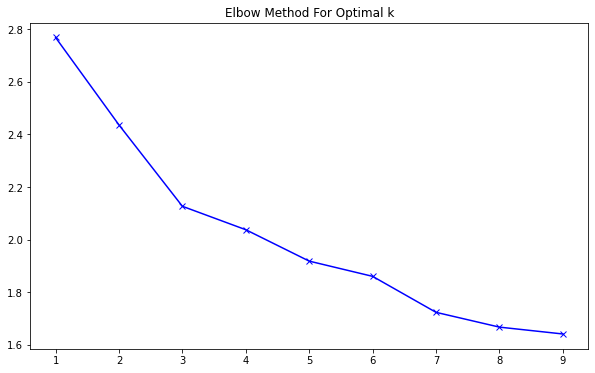

In [967]:
madrid_grouped_clustering = madrid_grouped.drop('Neighbourhood', 1)
sum_of_squared_distances = []
K = range(1,10)

for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=20).fit(madrid_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')

__Clustering neighbourhoods__

Run _k_-means to cluster the neighbourhoods into 5 clusters.

In [968]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=100).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 0, 3, 2, 1, 0, 2, 2, 2], dtype=int32)

__Creating a dataframe with cluster labels and top venues__

In [971]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

madrid_merged = df_madrid

# merge madrid_grouped with df_madrid to add latitude/longitude for each neighbourhood
madrid_merged = madrid_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

madrid_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PALACIO,40.41517,-3.71273,2,Church,Restaurant,Spanish Restaurant,Mexican Restaurant,Plaza,Monument / Landmark,Historic Site,Office,Korean Restaurant,Furniture / Home Store
1,EMBAJADORES,40.40803,-3.70067,2,Spanish Restaurant,Tapas Restaurant,Bar,Indian Restaurant,Restaurant,Salon / Barbershop,Coffee Shop,Food & Drink Shop,Theater,Pizza Place
2,CORTES,40.41589,-3.69636,0,Spanish Restaurant,Office,Restaurant,Government Building,Tapas Restaurant,Capitol Building,Hotel,Japanese Restaurant,Hotel Bar,Building
3,JUSTICIA,40.42479,-3.69308,1,Art Gallery,Office,Courthouse,Boutique,Food,Restaurant,Embassy / Consulate,Building,Women's Store,Post Office
4,UNIVERSIDAD,40.42565,-3.70726,2,Café,Bookstore,Bar,Government Building,Office,Hotel,Bed & Breakfast,Coworking Space,Mexican Restaurant,Metro Station


__Visualizing the clusters__

In [972]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, area, cluster in zip(madrid_merged['Latitude'], madrid_merged['Longitude'], madrid_merged['Neighbourhood'], madrid_merged['Cluster Labels']):
    label = folium.Popup(remove_accents(str(area)) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

__Examining clusters__

Let's find the residential clusters by examining the discriminating venue categories.

__Cluster 0__

In [973]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[0] + list(range(4, madrid_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,CORTES,Spanish Restaurant,Office,Restaurant,Government Building,Tapas Restaurant,Capitol Building,Hotel,Japanese Restaurant,Hotel Bar,Building
5,SOL,Clothing Store,Jewelry Store,Plaza,Miscellaneous Shop,Accessories Store,Hostel,Art Gallery,Building,Housing Development,Bookstore
6,IMPERIAL,Bar,Office,Laundry Service,Residential Building (Apartment / Condo),Factory,Korean Restaurant,Gas Station,Trade School,Automotive Shop,Bakery
9,LEGAZPI,Office,Pharmacy,Bus Line,Supermarket,Pizza Place,Grocery Store,General Entertainment,Spanish Restaurant,Residential Building (Apartment / Condo),Bar
10,DELICIAS,Office,Nursery School,Automotive Shop,Restaurant,Gym / Fitness Center,School,Building,Coffee Shop,Mediterranean Restaurant,Design Studio
12,ATOCHA,Office,Train Station,Coworking Space,Bank,Breakfast Spot,Tech Startup,Coffee Shop,Building,Professional & Other Places,Diner
14,ADELFAS,Office,Bank,Spanish Restaurant,Bar,Salon / Barbershop,Pharmacy,Assisted Living,Coffee Shop,Auto Dealership,General Entertainment
18,NIÑO JESÚS,Spanish Restaurant,Office,Plaza,Government Building,Café,Doctor's Office,Restaurant,Bank,Farmers Market,Sports Club
21,FUENTE DEL BERRO,Spanish Restaurant,Office,Medical Center,Restaurant,Building,Bakery,Doctor's Office,Tapas Restaurant,Supermarket,Farmers Market
22,GUINDALERA,Office,Spanish Restaurant,Bar,Bank,General Entertainment,Automotive Shop,Medical Center,Grocery Store,Cocktail Bar,Nail Salon


__Cluster 1__

In [974]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[[0] + list(range(4, madrid_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,JUSTICIA,Art Gallery,Office,Courthouse,Boutique,Food,Restaurant,Embassy / Consulate,Building,Women's Store,Post Office
17,LOS JERÓNIMOS,Office,Art Gallery,Non-Profit,Restaurant,Café,Building,Coffee Shop,Coworking Space,Cocktail Bar,Clothing Store
19,RECOLETOS,Boutique,Office,Cosmetics Shop,Clothing Store,Jewelry Store,Shoe Store,Women's Store,Accessories Store,Miscellaneous Shop,Men's Store
24,CASTELLANA,Office,Bank,Building,Restaurant,Tech Startup,Café,Tapas Restaurant,Diner,Doctor's Office,Pharmacy
27,CIUDAD JARDÍN,Office,Tech Startup,Building,Pharmacy,Café,Bus Stop,Restaurant,Real Estate Office,Other Great Outdoors,Supermarket
29,NUEVA ESPAÑA,Office,Medical Center,Embassy / Consulate,Coworking Space,Building,Dentist's Office,Student Center,Other Great Outdoors,Doctor's Office,Salon / Barbershop
30,CASTILLA,Office,Coworking Space,Building,Bank,General Entertainment,Tech Startup,Medical Center,Bar,Pool,Other Great Outdoors
33,CASTILLEJOS,Office,Bank,Spanish Restaurant,Gym,Coworking Space,Italian Restaurant,Residential Building (Apartment / Condo),Asian Restaurant,Building,Hotel
40,ALMAGRO,Office,Building,Spanish Restaurant,Professional & Other Places,Business Center,Tech Startup,Modern European Restaurant,Art Gallery,Restaurant,College Lab
56,EL PLANTÍO,Office,Coworking Space,Building,Boutique,Clothing Store,Spanish Restaurant,Jewelry Store,Restaurant,Salon / Barbershop,Mediterranean Restaurant


__Cluster 2__

In [975]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 2, madrid_merged.columns[[0] + list(range(4, madrid_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PALACIO,Church,Restaurant,Spanish Restaurant,Mexican Restaurant,Plaza,Monument / Landmark,Historic Site,Office,Korean Restaurant,Furniture / Home Store
1,EMBAJADORES,Spanish Restaurant,Tapas Restaurant,Bar,Indian Restaurant,Restaurant,Salon / Barbershop,Coffee Shop,Food & Drink Shop,Theater,Pizza Place
4,UNIVERSIDAD,Café,Bookstore,Bar,Government Building,Office,Hotel,Bed & Breakfast,Coworking Space,Mexican Restaurant,Metro Station
7,ACACIAS,Salon / Barbershop,Bank,Non-Profit,Park,Pizza Place,Medical Center,Bar,Doctor's Office,General College & University,Office
8,CHOPERA,Bar,Bank,Tapas Restaurant,Miscellaneous Shop,Restaurant,Spanish Restaurant,Plaza,Breakfast Spot,Italian Restaurant,Coffee Shop
11,PALOS DE MOGUER,Bank,Salon / Barbershop,Spanish Restaurant,Restaurant,Bar,Grocery Store,Dentist's Office,Snack Place,Furniture / Home Store,Miscellaneous Shop
13,PACÍFICO,Bar,Medical Center,Bakery,Miscellaneous Shop,Diner,Office,General Entertainment,Grocery Store,Salon / Barbershop,Bank
15,ESTRELLA,Bar,Office,Grocery Store,Salon / Barbershop,Bank,Coffee Shop,Doctor's Office,Building,Pub,School
16,IBIZA,Tapas Restaurant,Bank,Salon / Barbershop,Bar,Pizza Place,Bakery,Spanish Restaurant,Kids Store,Deli / Bodega,Italian Restaurant
20,GOYA,Cosmetics Shop,Women's Store,Bank,Spanish Restaurant,Bus Line,Jewelry Store,Office,Bus Station,Salon / Barbershop,Mobile Phone Shop


__Cluster 3__

In [976]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 3, madrid_merged.columns[[0] + list(range(4, madrid_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
127,AEROPUERTO,Airport Gate,Airport Service,Rental Car Location,Accessories Store,Coworking Space,Restaurant,Sandwich Place,Office,Transportation Service,Newsstand


__Cluster 4__

In [977]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 4, madrid_merged.columns[[0] + list(range(4, madrid_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,EL GOLOSO,College Classroom,University,College Library,College Administrative Building,College Cafeteria,College Lab,College Arts Building,College Academic Building,College Science Building,Post Office
53,CIUDAD UNIVERSITARIA,College Classroom,College Library,College Cafeteria,University,College Auditorium,College Administrative Building,College Quad,Music Venue,College Academic Building,General College & University


__Selecting a cluster__

By exploring the most frequent venues of each of the five clusters we can describe the clusters as follows:

| Cluster | Type of area |
| :------ | :----------: |
|  0      | Recreation   |
|  1      | Business     |
|  2      | Residential  |
|  3      | Airport      |
|  4      | Student      |

Therefore we will deeply analyse the cluster 2 in detail since this is the one that refers to residential areas. This cluster contains 76 neighbourhoods.

In [978]:
# From now on, work only with residential neighbourhoods
residential_cluster_id = 2
df_madrid_residential = df_madrid[df_madrid['Neighbourhood'].isin(madrid_merged.loc[madrid_merged['Cluster Labels'] == residential_cluster_id, 'Neighbourhood'])]

__Counting supermarkets in residential neighbourhoods__

In [982]:
# Category ID in Foursquare API
supermarket_category = '52f2ab2ebcbc57f1066b8b46'

# Function to count the number of market-like venues in a given neighbourhood
def getMarketVenues(row):
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        row['Latitude'], 
        row['Longitude'],
        supermarket_category,
        radius, 
        LIMIT)

    # make the GET request and get get length of venues
    count = len(requests.get(url).json()["response"]['venues'])

    # return count
    return pd.Series(count)

__Run the above function on each residential neighbourhood__

In [983]:
df_madrid_residential['Number of Markets'] = df_madrid_residential.apply(getMarketVenues, axis=1)

<ipython-input-983-653b1f31852b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_madrid_residential['Number of Markets'] = df_madrid_residential.apply(getMarketVenues, axis=1)


### Census analysis <a class="anchor" id="census-analysis"></a>

__Merge dataframes__

Merge dataframes with household income and population into the residential dataframe.

In [984]:
# Left join with income dataframe
df_madrid_residential = df_madrid_residential.merge(df_madrid_income, how='left', on='Neighbourhood')
print(df_madrid_residential.shape)
df_madrid_residential.head()

(76, 5)


,Neighbourhood,Latitude,Longitude,Number of Markets,Income
0,PALACIO,40.41517,-3.71273,33,34675
1,EMBAJADORES,40.40803,-3.70067,34,25999
2,UNIVERSIDAD,40.42565,-3.70726,49,30701
3,ACACIAS,40.40137,-3.70669,21,44669
4,CHOPERA,40.39536,-3.69833,20,31933


In [985]:
# Left join with population dataframe
df_madrid_residential = df_madrid_residential.merge(df_madrid_population, how='left', on='Neighbourhood')
print(df_madrid_residential.shape)
df_madrid_residential.head()

(76, 6)


,Neighbourhood,Latitude,Longitude,Number of Markets,Income,Population
0,PALACIO,40.41517,-3.71273,33,34675,23691.0
1,EMBAJADORES,40.40803,-3.70067,34,25999,47460.0
2,UNIVERSIDAD,40.42565,-3.70726,49,30701,33527.0
3,ACACIAS,40.40137,-3.70669,21,44669,36690.0
4,CHOPERA,40.39536,-3.69833,20,31933,20241.0


__Calculate proportion of markets__

Find how many people per one market live in each residential neighbourhood

In [986]:
df_madrid_residential['People per Market'] = df_madrid_residential.apply(lambda x: (x['Population'] // x['Number of Markets']) if x['Number of Markets'] > 0 else x['Population'], axis=1)
print(df_madrid_residential.shape)
df_madrid_residential

(76, 7)


,Neighbourhood,Latitude,Longitude,Number of Markets,Income,Population,People per Market
0,PALACIO,40.41517,-3.71273,33,34675,23691.0,717.0
1,EMBAJADORES,40.40803,-3.70067,34,25999,47460.0,1395.0
2,UNIVERSIDAD,40.42565,-3.70726,49,30701,33527.0,684.0
3,ACACIAS,40.40137,-3.70669,21,44669,36690.0,1747.0
4,CHOPERA,40.39536,-3.69833,20,31933,20241.0,1012.0
5,PALOS DE MOGUER,40.40301,-3.69358,25,33938,26021.0,1040.0
6,PACÍFICO,40.40191,-3.67603,10,41948,33411.0,3341.0
7,ESTRELLA,40.41117,-3.66593,9,58249,23305.0,2589.0
8,IBIZA,40.41794,-3.67626,19,45561,21805.0,1147.0
9,GOYA,40.42547,-3.67418,38,48814,29620.0,779.0


__Scatter plot with income vs people per market__

In [995]:
# Function to draw a scatter plot of residential neighbourhoods by household income and population per market.
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size=8, legend=False)
    # Add text besides each point
#    for line in range(0,data.shape[0]):
    texts = [p1.text(data[x][line], data[y][line], 
             data[text_column][line], horizontalalignment='left', 
             size='large', color='blue') for line in range(0,data.shape[0])]
    adjust_text(texts)
    # Set title and axis labels
    plt.title(title, size=18)
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    return p1

posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values


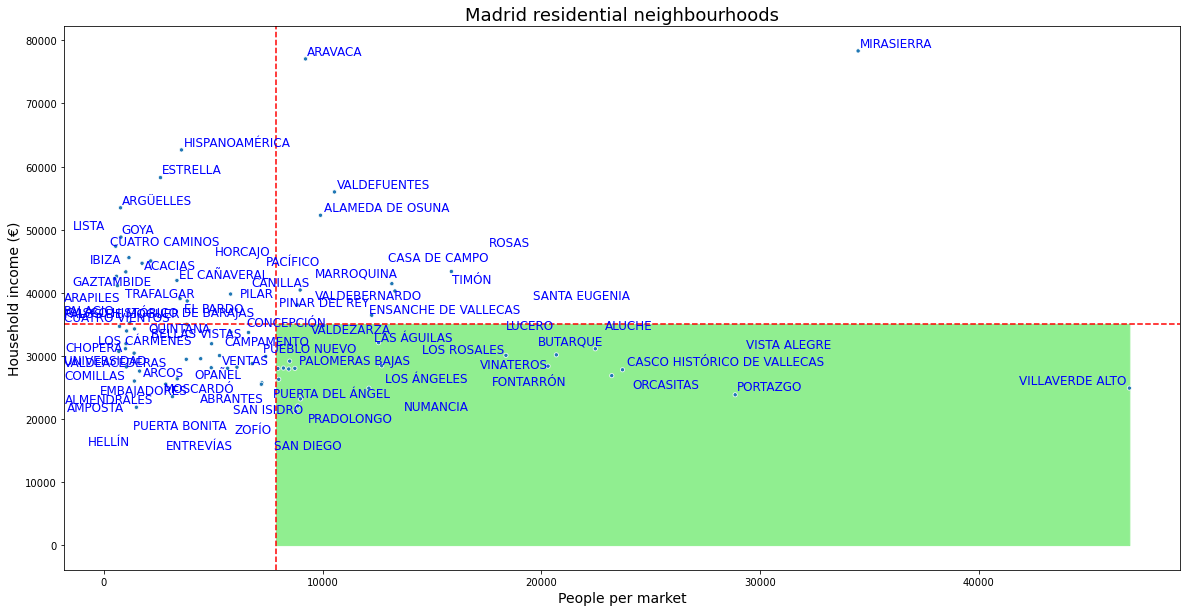

In [996]:
plt.figure(figsize=(20,10))

# Add horizontal and vertical lines to mark the median values
avg_people_per_market = df_madrid_residential['People per Market'].mean()
max_people_per_market = df_madrid_residential['People per Market'].max()
avg_income = df_madrid_residential['Income'].mean()

plt.axhline(y=avg_income, color='r', linestyle='--')
plt.axvline(x=avg_people_per_market, color='r', linestyle='--')

# Highlight the optimal quadrant
plt.fill_between(x=np.arange(avg_people_per_market, max_people_per_market), y1=0, y2=avg_income, color='lightgreen')

# Draw and label the neighbourhood points
scatter_text('People per Market', 'Income', 'Neighbourhood',
             data = df_madrid_residential, 
             title = 'Madrid residential neighbourhoods', 
             xlabel = 'People per market',
             ylabel = 'Household income (€)')

## Results and discussion <a class="anchor" id="results-and-discussion"></a>

In the above diagram, the highlighted area in green represents the most adequate areas to open a low-cost supermarket since their household income is below average and also their ratio of people per market is above average.

In particular, we can clearly see that Villaverde Alto looks the optimal neighbourhood since the household income is clearly under average (around 26K €) and there are very few supermarkets for the amount of population in the area.

However it would also be recommended to consider other similar areas such as Portazgo that is also located on the bottom-right corner of the plot.

It is also interesting to mention that even though the amount of existing supermarkets in Mirasierra does clearly not cover the demand of the neighbourhood, it would be a convenient place for a high class market since the household income there is at the very top.

## Conclusion <a class="anchor" id="conclusion"></a>

The neighbourhoods of Madrid were analysed with the purpose of finding the idial location for a new low-cost supermarket. We applied machine learning techniques such as k-means clustering to find different clusters so that we could focus in only one type of neighbourhood (residential). Further data such as population and market venues have been used to reduce the number of potential areas.

This project could be improved by only taking certain venue categories into consideration when performing the clustering segmentation. We could for example identify the key types of venue that define a residential area such as schools, pharmacies, small markets and corner shops, and the types of venue that discard a residential area such as night clubs, theaters and so on. Another improvement could be achieved by only handling certain groups of ages and social classes that would normally shop in a supermarket.

Although this project focuses particularly in a low-cost supermarket, it could easily be ammended for any type of business and city, as long as the corresponding data are available to be included in the analysis.